In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [23]:
df = pd.read_csv('/content/boxoffice.csv', encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


In [24]:
df.shape

(2694, 10)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


In [26]:
df.describe()

,domestic_revenue,world_revenue,opening_revenue,opening_theaters,budget,release_days
count,2.694000e+03,2.694000e+03,2.694000e+03,2694.000000,2.694000e+03,2694.000000
mean,1.508539e+08,7.719177e+08,9.971321e+07,2263.039347,1.537996e+08,90.897550
std,8.579997e+07,4.284414e+08,5.721762e+07,1298.559140,8.557624e+07,50.894041
min,8.277650e+05,3.261301e+06,1.385690e+05,10.000000,5.197977e+06,1.000000
25%,7.673272e+07,3.991135e+08,5.033848e+07,1161.000000,7.861876e+07,47.000000
50%,1.525725e+08,7.665551e+08,9.981418e+07,2271.500000,1.562567e+08,91.000000
75%,2.247314e+08,1.143920e+09,1.489805e+08,3392.250000,2.274832e+08,135.000000
max,2.998107e+08,1.499310e+09,1.999336e+08,4499.000000,2.998597e+08,179.000000


In [27]:
# removing world revenue and opening revenue to predict domestic revenue
to_remove = ['world_revenue','opening_revenue']
df.drop(to_remove, axis=1, inplace=True)

In [28]:
df.head()

,title,domestic_revenue,distributor,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,Warner Bros.,253,174687337,R,Animation,16
1,Titanic,169411543,Disney,122,103948486,G,Action,103
2,Jurassic Park,107836098,Sony,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,Disney,3868,46431596,G,Horror,85
4,The Lion King,142791649,Warner Bros.,2934,203513696,R,Comedy,158


In [29]:
df.shape

(2694, 8)

In [30]:
# missing values
df.isnull().sum()

,0
title,0
domestic_revenue,0
distributor,0
opening_theaters,0
budget,0
MPAA,0
genres,0
release_days,0


In [31]:
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
    df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()

np.int64(0)

In [32]:
for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
  df[col] = df[col].astype(str).str.replace(',', '')
  temp = (~df[col].isnull())
  df[temp][col] = df[temp][col].convert_dtypes(float)
  df[col] = pd.to_numeric(df[col], errors='coerce')

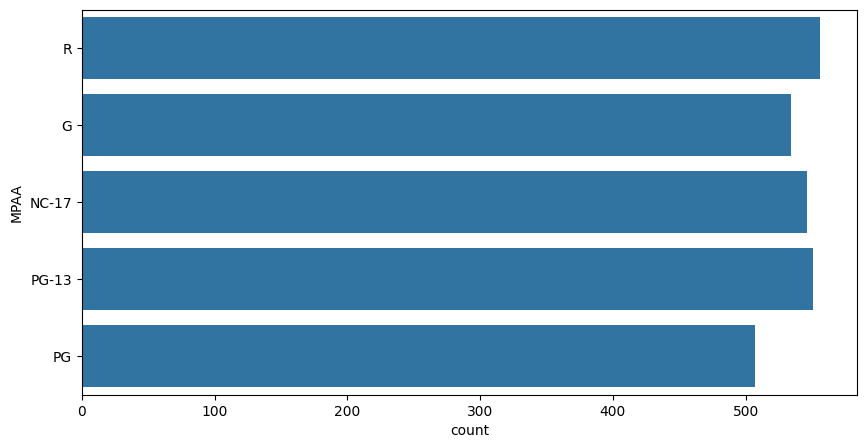

In [36]:
plt.figure(figsize=(10,5))
sns.countplot(df['MPAA'])
plt.show()

In [38]:
df.groupby('MPAA')['domestic_revenue'].mean()

,domestic_revenue
MPAA,
G,1.465288e+08
NC-17,1.507193e+08
PG,1.529123e+08
PG-13,1.477556e+08
R,1.563334e+08


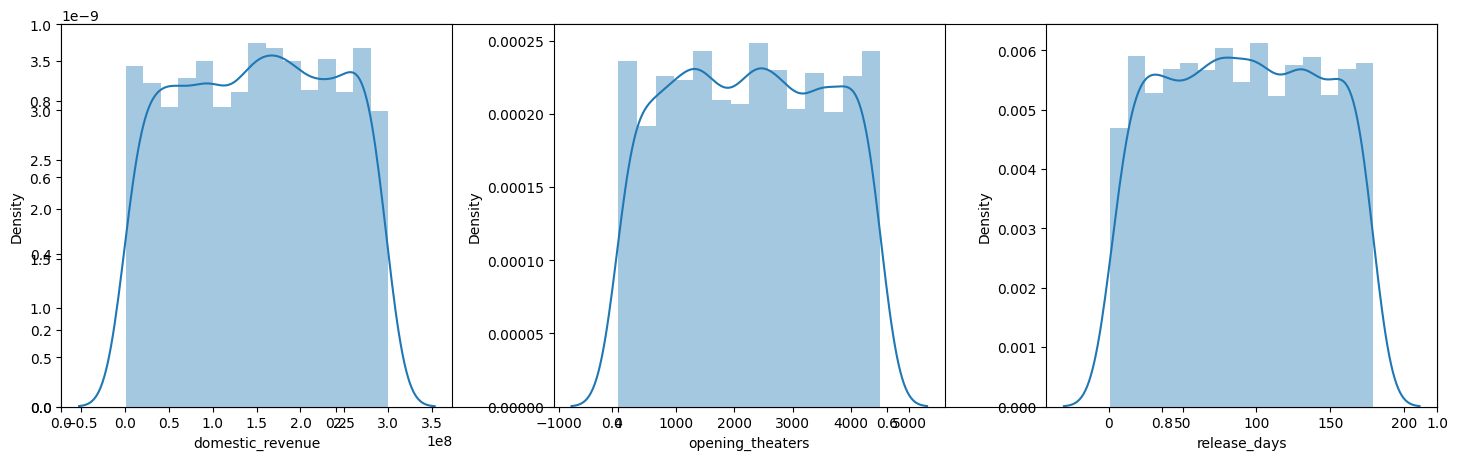

In [41]:
plt.subplots(figsize=(15, 5))
features = ['domestic_revenue', 'opening_theaters', 'release_days']

for i, col in enumerate(features):
  plt.subplot(1,3,i+1)
  sns.distplot(df[col])
plt.tight_layout()
plt.show()

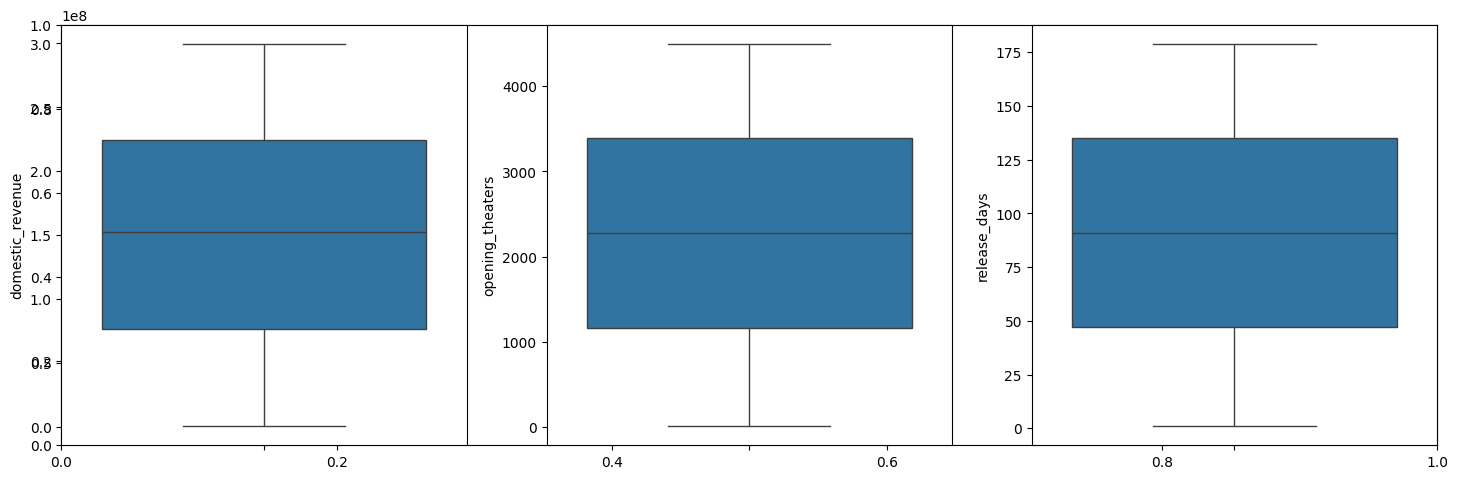

In [43]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(df[col])
plt.tight_layout()
plt.show()

In [44]:
for col in features:
  df[col] = df[col].apply(lambda x: np.log10(x))

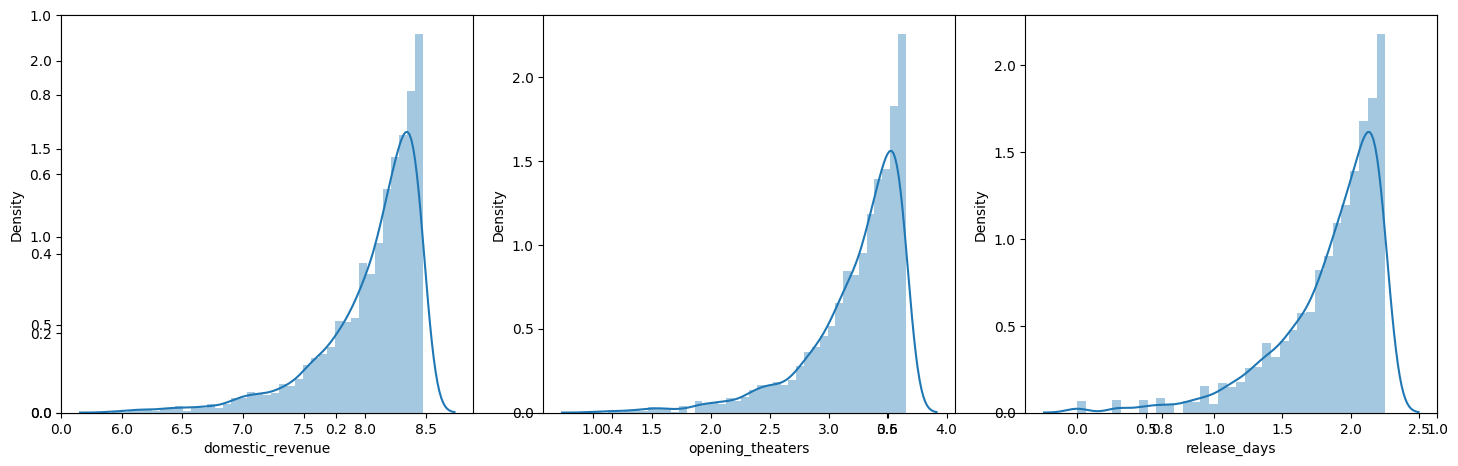

In [46]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.distplot(df[col])
plt.tight_layout()
plt.show()

In [51]:
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()

genres = vectorizer.get_feature_names_out()
for i, name in enumerate(genres):
  df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True)

In [52]:
df.head()

,title,domestic_revenue,distributor,opening_theaters,MPAA,release_days,action,animation,comedy,drama,horror,thriller
0,The Avengers,6.780065,Warner Bros.,2.403121,R,1.204120,0,1,0,0,0,0
1,Titanic,8.228943,Disney,2.086360,G,2.012837,1,0,0,0,0,0
2,Jurassic Park,8.032764,Sony,3.582745,NC-17,1.949390,0,0,0,0,1,0
3,Avatar,7.711248,Disney,3.587486,G,1.929419,0,0,0,0,1,0
4,The Lion King,8.154703,Warner Bros.,3.467460,R,2.198657,0,0,1,0,0,0


In [53]:
removed = 0

if 'action' in df.columns and 'western' in df.columns:
    for col in df.loc[:, 'action':'western'].columns:

        if (df[col] == 0).mean() > 0.95:
            removed += 1
            df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)

0
(2694, 12)


In [55]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.head()

,title,domestic_revenue,distributor,opening_theaters,MPAA,release_days,action,animation,comedy,drama,horror,thriller
0,The Avengers,6.780065,4,2.403121,4,1.204120,0,1,0,0,0,0
1,Titanic,8.228943,0,2.086360,0,2.012837,1,0,0,0,0,0
2,Jurassic Park,8.032764,2,3.582745,1,1.949390,0,0,0,0,1,0
3,Avatar,7.711248,0,3.587486,0,1.929419,0,0,0,0,1,0
4,The Lion King,8.154703,4,3.467460,4,2.198657,0,0,1,0,0,0


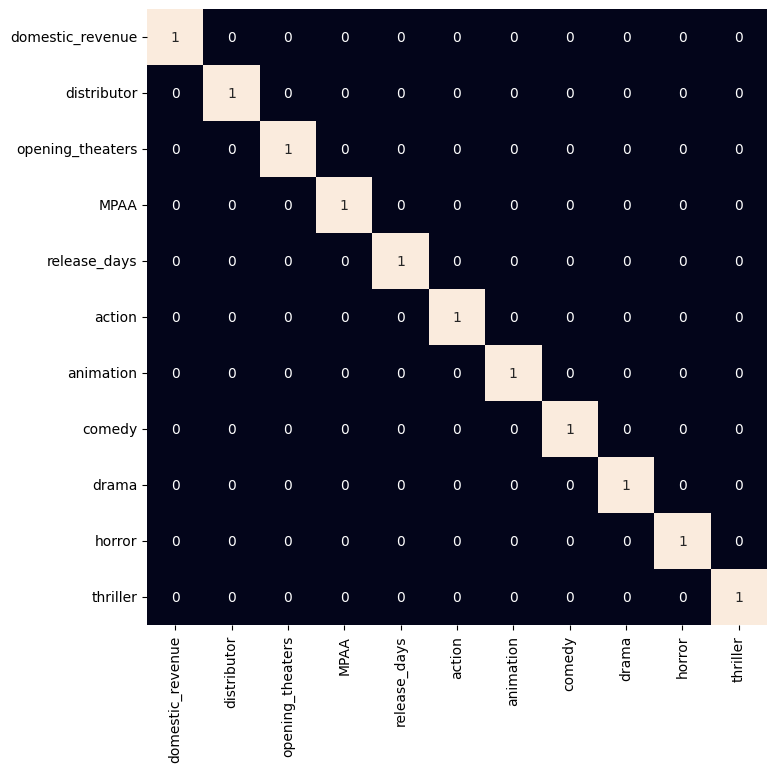

In [65]:
plt.figure(figsize=(8, 8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(df.select_dtypes(include=np.number).corr()>0.8, annot=True, cbar=False)
plt.show()

In [76]:
X = df.drop(['title', 'domestic_revenue'], axis=1)
y = df['domestic_revenue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape

((1804, 10), (890, 10))

In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
from sklearn.metrics import mean_absolute_error as mae
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [88]:
train_preds = model.predict(X_train)
print('Training Error : ', mae(y_train, train_preds))
val_preds = model.predict(X_test)
print('Validation Error : ', mae(y_test, val_preds))
print()

Training Error :  0.0868974793584019
Validation Error :  0.35334138290663797



In [ ]:
# Conclusion:
# The model exhibits a training MAE of 0.0869 and a validation MAE of 0.3533.
# This indicates that the model is overfitting to the training data, as its performance on unseen data is considerably worse.
# meaning it performs well on training data but not as well on unseen (validation) data.
# Further optimization, such as hyperparameter tuning or using regularization techniques, may be necessary to improve the model's generalization capabilities.